
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [12]:
import pandas as pd
import numpy as np
import torch

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [3]:
#Dropout: 5%, 15%, 25%, 35%, and 50%
DROPOUT = 0.05

#Learning rate: 5e-4, 1e-3, 5e-3, 1e-2
LEARNING_RATE = 5e-4

In [4]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModel.from_pretrained("xlm-roberta-large")

In [5]:
df = pd.read_csv('../datasets/buscape_preprocessed_balanced_cleared.csv')

In [6]:
df.head(3)

,review_text,rating
0,nao comparia novamente essa marca pois paguei ...,0
1,tem uma boa aderencia te da mas agilidades no ...,0
2,somente mais um jogo do estilo nada realmente ...,0


In [7]:
print(f'{df.shape[0]} instancias, {df.shape[1]} classes')

13620 instancias, 2 classes


#### Dividindo dataset em dois batchs, 50% cada

In [8]:
reviews_batch_01, reviews_batch_02, labels_batch_01, labels_batch_02 = train_test_split(df['review_text'], df['rating'], test_size=0.5, random_state=42)

In [19]:
print(f'batch_01: {reviews_batch_01.shape[0]} instancias')
print(f'batch_02: {reviews_batch_02.shape[0]} instancias')

batch_01: 6810 instancias
batch_02: 6810 instancias


#### Quantidade de avaliações positivas e negativas no batch_01

In [9]:
labels_batch_01.value_counts()

rating
1    3419
0    3391
Name: count, dtype: int64

In [10]:
reviews = reviews_batch_01
labels = labels_batch_01

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [14]:
embeddings = []
for review in reviews:
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

In [15]:
embeddings_array = np.vstack(embeddings)

In [16]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

6810 embeddings de 1024 dimensões


#### Feature based 1

In [17]:
additional_features = np.array([[len(review.split())] for review in reviews_batch_02])

In [18]:
print(embeddings_array.shape)
print(additional_features.shape)

(6810, 1024)
(6810, 1)


#### Combinando embeddings_array e additional_features

In [19]:
combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [22]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [23]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [24]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                24624     
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 24,649
Trainable params: 24,649
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

#### Cross-validation

In [26]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

#### Ajustando path para salvar os pesos

In [28]:
CHECKPOINT=ModelCheckpoint(filepath='../weights/tlm_gran_weights.hdf5', verbose=1, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [CHECKPOINT, EARLY_STOP]

#### Treinamento do modelo

fold = 1
Epoch 1/10
176/192 [==========================>...] - ETA: 0s - loss: 0.7720 - accuracy: 0.6232
Epoch 1: val_loss improved from inf to 0.51292, saving model to ../weights/tlm_gran_weights.hdf5
192/192 [==============================] - 1s 3ms/step - loss: 0.7587 - accuracy: 0.6291 - val_loss: 0.5129 - val_accuracy: 0.7797
Epoch 2/10
176/192 [==========================>...] - ETA: 0s - loss: 0.5339 - accuracy: 0.7399
Epoch 2: val_loss improved from 0.51292 to 0.44599, saving model to ../weights/tlm_gran_weights.hdf5
192/192 [==============================] - 0s 2ms/step - loss: 0.5281 - accuracy: 0.7458 - val_loss: 0.4460 - val_accuracy: 0.7944
Epoch 3/10
184/192 [===========================>..] - ETA: 0s - loss: 0.4856 - accuracy: 0.7775
Epoch 3: val_loss improved from 0.44599 to 0.42176, saving model to ../weights/tlm_gran_weights.hdf5
192/192 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.7778 - val_loss: 0.4218 - val_accuracy: 0.8164
Epoch 4/10


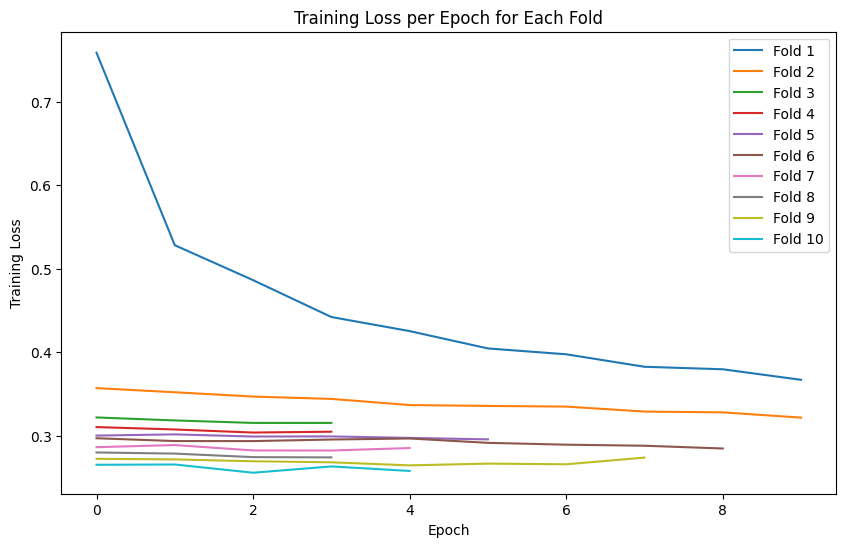

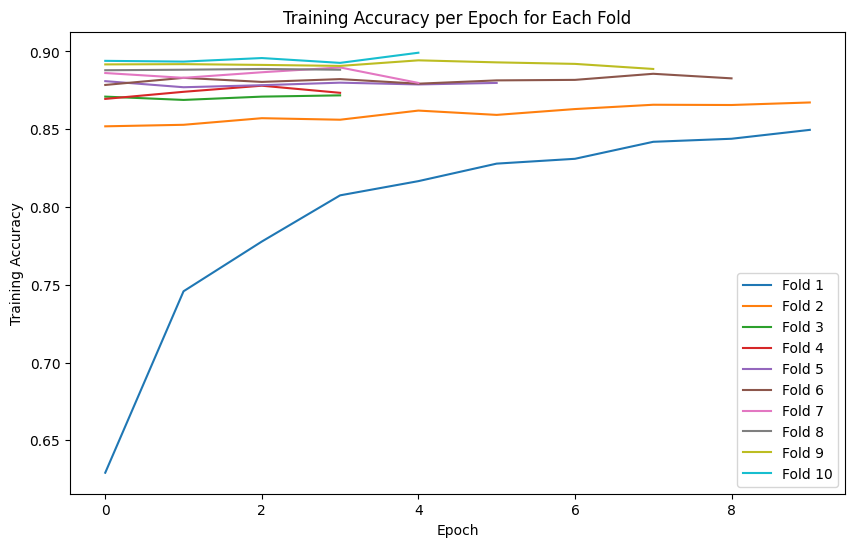

In [29]:
fold = 0

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in kf.split(combined_features):
    fold+=1
    print(f'fold = {fold}')
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=1,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS,
    )
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
print("Cross-Validation Accuracies:", fold_accuracies)
print("Cross-Validation Scores:", fold_f1_scores)
print("Media Accuracy:", np.mean(fold_accuracies))
print("Media f1 score:", np.mean(fold_f1_scores))

plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.show()

In [30]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)

43/43 [==============================] - 0s 1ms/step - loss: 0.2349 - accuracy: 0.9141


In [31]:
def load_weights_from_hdf5(model, weight_path):
    model.load_weights(weight_path)
    return model

In [32]:
tlm_gran_weights_path = '../weights/tlm_gran_weights.hdf5'
model = load_weights_from_hdf5(model, tlm_gran_weights_path)

fold = 1
Epoch 1/10
179/192 [==========================>...] - ETA: 0s - loss: 0.2797 - accuracy: 0.8851
Epoch 1: val_loss improved from 0.25646 to 0.24000, saving model to ../weights/tlm_gran_weights.hdf5
192/192 [==============================] - 0s 2ms/step - loss: 0.2781 - accuracy: 0.8861 - val_loss: 0.2400 - val_accuracy: 0.9016
Epoch 2/10
170/192 [=========================>....] - ETA: 0s - loss: 0.2771 - accuracy: 0.8868
Epoch 2: val_loss did not improve from 0.24000
192/192 [==============================] - 0s 2ms/step - loss: 0.2783 - accuracy: 0.8871 - val_loss: 0.2541 - val_accuracy: 0.8957
Epoch 3/10
173/192 [==========================>...] - ETA: 0s - loss: 0.2781 - accuracy: 0.8851
Epoch 3: val_loss improved from 0.24000 to 0.23110, saving model to ../weights/tlm_gran_weights.hdf5
192/192 [==============================] - 0s 2ms/step - loss: 0.2776 - accuracy: 0.8863 - val_loss: 0.2311 - val_accuracy: 0.9075
Epoch 4/10
175/192 [==========================>...] - ETA: 0s

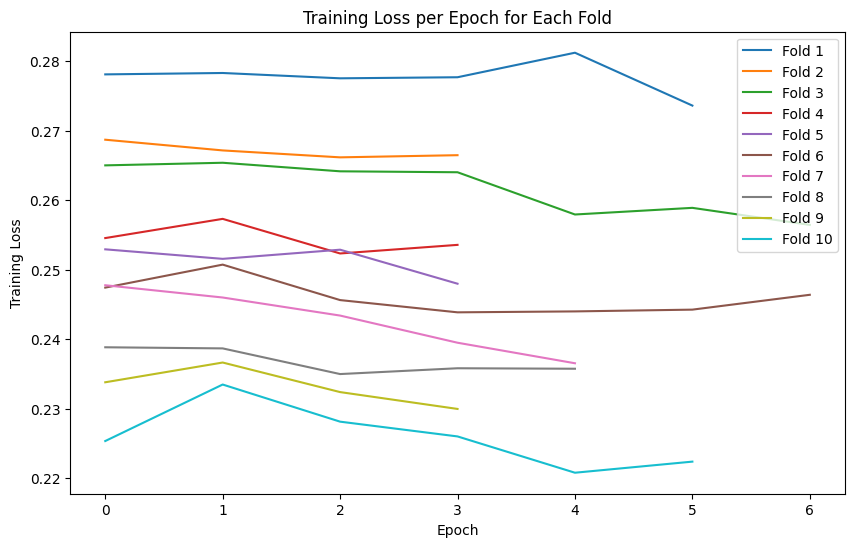

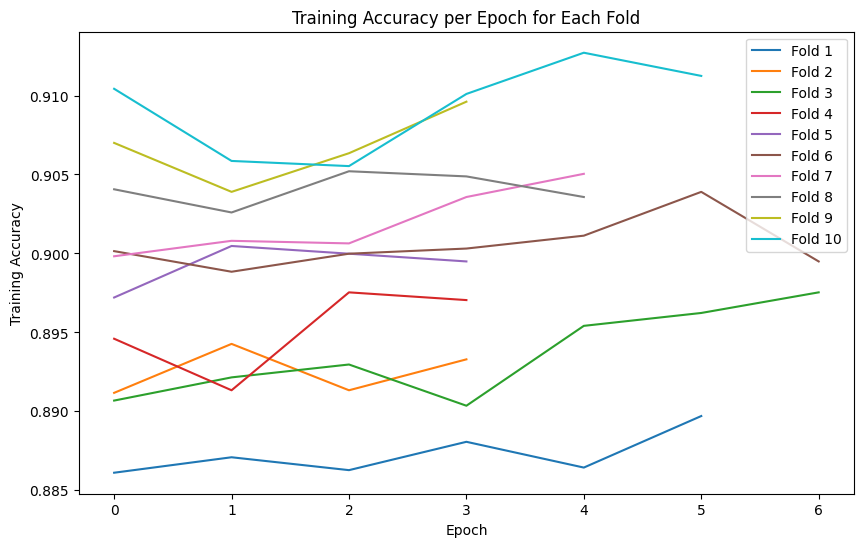

In [33]:
fold = 0

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in kf.split(combined_features):
    fold+=1
    print(f'fold = {fold}')
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    # Convertendo dados treino em tensores
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    # Convertendo dados de validacao em tensores
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=1,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS
    )
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
print("Cross-Validation Accuracies:", fold_accuracies)
print("Cross-Validation Scores:", fold_f1_scores)
print("Media Accuracy:", np.mean(fold_accuracies))
print("Media f1 score:", np.mean(fold_f1_scores))

plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.show()